# Forecasting

Forecast the incident volume in different fields , quarterly and annual. So that they can be better prepared with resources and technology planning.

> To determine the incident volumne we are considering the column 'Open-Time'

## Load Data

In [1]:
from sqlalchemy import create_engine
import pandas as pd

db_host = '18.136.56.185'
username ='dm_team'
pwd='dm_team123#'
db_name='project_itsm'

#Connecting to SQL DB
conn =create_engine('mysql+pymysql://'+username+':'+pwd+'@'+db_host+'/'+db_name)
conn.table_names()

query ='select * from dataset_list '
df =pd.read_sql(query,conn )
print(df.shape)
df.head(2)

(46606, 25)


,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,...,,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,,


In [2]:
df.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

### Considering columns 'Incident_ID','Open_Time'

In [3]:
df1 = df.loc[:,['Incident_ID','Open_Time']]
df1.head()

,Incident_ID,Open_Time
0,IM0000004,05-02-2012 13:32
1,IM0000005,12-03-2012 15:44
2,IM0000006,29-03-2012 12:36
3,IM0000011,17-07-2012 11:49
4,IM0000012,10-08-2012 11:01


### Data Processing

In [4]:
import datetime

df1['Open_Time'] =pd.to_datetime(df1['Open_Time'])
df1['Open_Time'] = df1['Open_Time'].dt.date
df1

,Incident_ID,Open_Time
0,IM0000004,2012-05-02
1,IM0000005,2012-12-03
2,IM0000006,2012-03-29
3,IM0000011,2012-07-17
4,IM0000012,2012-10-08
...,...,...
46601,IM0047053,2014-03-31
46602,IM0047054,2014-03-31
46603,IM0047055,2014-03-31
46604,IM0047056,2014-03-31


In [5]:
# Adding a new column which will have the number of tickets per day
df1['No_Incidents'] = df1.groupby('Open_Time')['Incident_ID'].transform('count')
df1.drop(['Incident_ID'],axis=1,inplace=True)
df1.drop_duplicates(inplace=True)


In [6]:
df1.head(3)

,Open_Time,No_Incidents
0,2012-05-02,1
1,2012-12-03,1
2,2012-03-29,1


In [7]:
# Setting Date as the Index
df1 = df1.set_index('Open_Time')
df1.index = pd.to_datetime(df1.index)
df1.index

DatetimeIndex(['2012-05-02', '2012-12-03', '2012-03-29', '2012-07-17',
               '2012-10-08', '2012-08-15', '2012-08-22', '2012-08-29',
               '2012-03-09', '2012-09-21',
               ...
               '2014-03-22', '2014-03-24', '2014-03-23', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=331, freq=None)

In [8]:
df1.head()

,No_Incidents
Open_Time,
2012-05-02,1
2012-12-03,1
2012-03-29,1
2012-07-17,1
2012-10-08,2


In [9]:
# Making a new Series with frequency as Day
df = df1['No_Incidents']
df = df.asfreq('D')
df.index

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06', '2012-05-07', '2012-05-08', '2012-05-09',
               '2012-05-10', '2012-05-11',
               ...
               '2014-03-22', '2014-03-23', '2014-03-24', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=699, freq='D')

In [10]:
df.head()

Open_Time
2012-05-02    1.0
2012-05-03    NaN
2012-05-04    NaN
2012-05-05    NaN
2012-05-06    NaN
Freq: D, Name: No_Incidents, dtype: float64

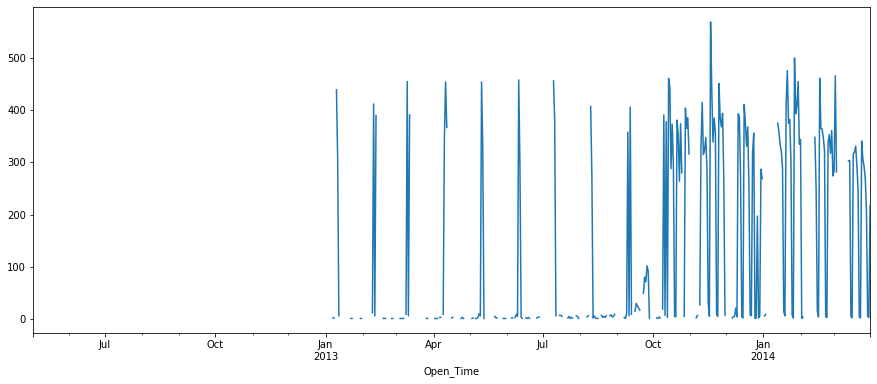

In [12]:
import matplotlib.pyplot as plt

# Plotting number of tickets per day
df.plot(figsize=(15,6))
plt.show()

#Plotting determines that we can consider the values from Jan'2013

In [30]:
import itertools

# Making a list of values for p,d & q
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

### Defining Model

In [38]:
#import statsmodels.api as sm

import statsmodels.tsa.api as tsa

# Checking the AIC values per pairs
for param in pdq:
    mod = tsa.SARIMAX(df,order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:4068.5416740843393
ARIMA(0, 0, 1) - AIC:3957.746287189905
ARIMA(0, 1, 0) - AIC:4013.327945697519
ARIMA(0, 1, 1) - AIC:3872.0784496833944
ARIMA(1, 0, 0) - AIC:3903.5155476556997
ARIMA(1, 0, 1) - AIC:3874.853028943144
ARIMA(1, 1, 0) - AIC:3973.4465337858983
ARIMA(1, 1, 1) - AIC:3844.618354542599


In [34]:
# Choosing the model with minimum AIC and the ARIMA Model for Time Series Forecasting
mod = sm.tsa.statespace.SARIMAX(df,order=(1,1,1))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3286      0.053      6.176      0.000       0.224       0.433
ma.L1         -0.9696      0.011    -86.577      0.000      -0.992      -0.948
sigma2      2.059e+04   1368.855     15.043      0.000    1.79e+04    2.33e+04


In [35]:
# Predicting the future values and the confidence interval
pred = results.get_prediction(start=pd.to_datetime('2014-3-3'),end=pd.to_datetime('2014-10-30'),dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.round()

2014-03-03    322.0
2014-03-04    261.0
2014-03-05    254.0
2014-03-06    251.0
2014-03-07    250.0
              ...  
2014-10-26    223.0
2014-10-27    223.0
2014-10-28    223.0
2014-10-29    223.0
2014-10-30    223.0
Freq: D, Length: 242, dtype: float64

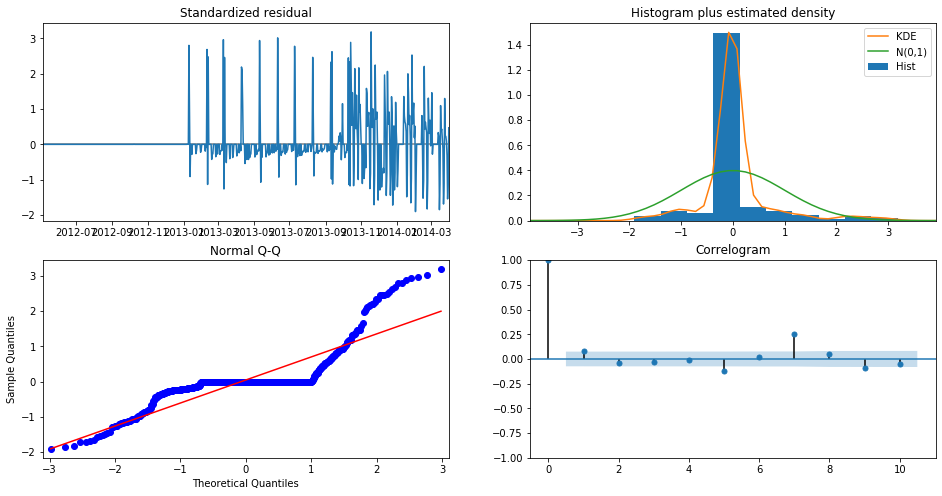

In [39]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

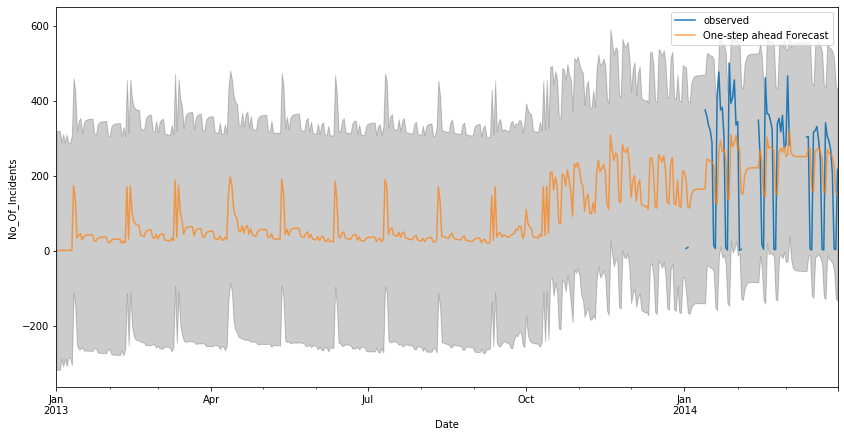

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('No_Of_Incidents')
plt.legend()
plt.show()

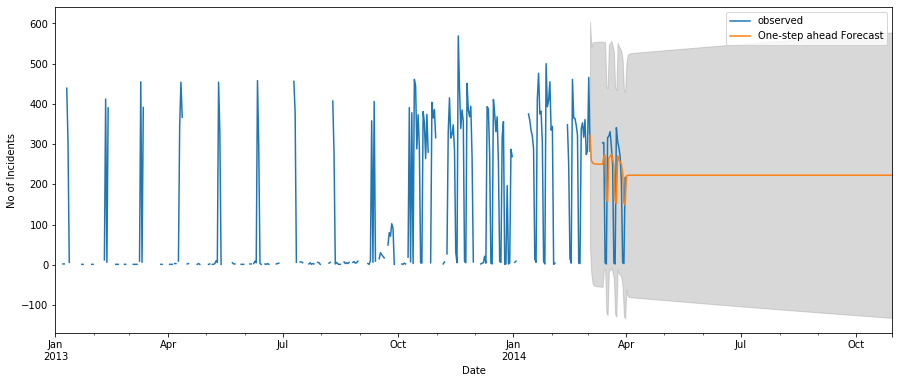

In [36]:
ax = df['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',figsize=(15, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='grey',alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('No of Incidents')
plt.legend()
plt.show()

## # Weekly ,day wise break down

In [ ]:

df_forecast['Created'].value_counts().sort_index(level='month').plot(kind='bar',title='Month-wise accident')

### month day wise breakdown
df['DAY'].value_counts().sort_index().plot(ax=axes[0,1],title='Day-wise accident')

####### week day break down
day = {1: '1_SAT', 2: '2_SUN', 3: '3_MON', 4: '4_TUE', 
          5: '5_WED', 6: '6_THU', 7: '7_FRI'}
df['day_week']=df['DAY_WEEK'].apply(lambda x: day[x])
df['day_week'].value_counts().sort_index().plot(ax=axes[1,0],kind='bar',title='Week_Day-wise accident')